In [23]:
import numpy as np
import matplotlib.pyplot as plt 
import random
np.set_printoptions(threshold=np.inf)
data = np.load('mnist.npz')
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']
x_train = (x_train.reshape(60000, 784))/255
x_test = (x_test.reshape(10000, 784))/255

In [24]:
def getPCA_Data(data,mean):
    data = data - mean
    cov = data.T @ data/10664
    eigenvalues,eigenvectors = np.linalg.eig(cov)
    idx = np.argsort(eigenvalues)[::-1]
    U = eigenvectors[:,idx]
    U = np.real(U)
    U = U[:,:5]
    Y = U.T @ data.T
    Y = Y.T
    Y = np.real(Y)
    return Y, U

In [25]:
#Consider the above as a regression problem. Apply gradient boosting
#using absolute loss and report the MSE between predicted and actual values of
#test set.
#The splits to be evaluated will be midpoint of two
#consecutive unique values. Find the best split by minimizing SSR. Denote
#this as h1(x). 
def find_best_split(data, splits, labels):
    min_ssr = float('inf')
    best_split = 0
    best_split_dim = 0
    best_left_mean = 0
    best_right_mean = 0
    for i in range(5):
        for j in range(1000):
            split = splits[i][j]
            left_data_indices = np.where(data[:,i] < split)
            right_data_indices = np.where(data[:,i] >= split)
            left_labels = labels[left_data_indices]
            right_labels = labels[right_data_indices]
            left_mean = np.mean(left_labels)
            right_mean = np.mean(right_labels)
            left_ssr = np.sum((np.abs(left_labels - left_mean))**2)
            right_ssr = np.sum((np.abs(right_labels - right_mean))**2)
            ssr = left_ssr + right_ssr
            if ssr < min_ssr:
                min_ssr = ssr
                best_split = split
                best_split_dim = i
                best_left_mean = left_mean
                best_right_mean = right_mean
    return best_split, best_split_dim,min_ssr, best_left_mean, best_right_mean
            
    


In [26]:
#we compute the residuals using y - 0.1*h1(x)
def compute_residuals(data, labels, split, split_dim, left_mean, right_mean):
    residuals = np.zeros(len(labels))
    for i in range(len(labels)):
        if data[i][split_dim] < split:
            residuals[i] = labels[i] - 0.01*left_mean
        else:
            residuals[i] = labels[i] - 0.01*right_mean
    return residuals

In [27]:
#update the labels using the residuals
def update_labels(labels, residuals):
    new_labels = [0]*len(labels)
    for i in range(len(labels)):
        new_labels[i] = residuals[i]
    return np.array(new_labels)

In [28]:
#function to predict the labels for a given dataset
def predict_labels_individual(data, split, split_dim, left_mean, right_mean):
    preds = np.zeros(len(data))
    for i in range(len(data)):
        if data[i][split_dim] < split:
            preds[i] = left_mean
        else:
            preds[i] = right_mean
    return preds

best_split1, best_split_dim1, best_left_mean1, best_right_mean1

In [29]:
def predict_labels_cumulative(models, data):
    preds = np.zeros(len(data))
    for model in models:
        preds += 0.01*predict_labels_individual(data, model[0], model[1], model[2], model[3])
    return preds

In [30]:
#compute MSE between predicted and actual labels
def compute_MSE(preds_arr, labels):
    #mse = (actual - (pred1 + pred2 + pred3 + pred4 + pred5)*0.01)**2
    temp = np.array(preds_arr)
    mse = np.mean((labels - np.sum(temp, axis = 0)*0.01)**2)
    return mse

In [31]:
def compute_MSE_test(preds_arr, labels):
    temp = np.array(preds_arr)
    mse = np.mean((labels - np.sum(temp, axis = 0)*0.01)**2)
    return mse/10


In [32]:
class0 = x_train[y_train == 0]
class1 = x_train[y_train == 1]
print(class0.shape, class1.shape)
labels = [-1]*class0.shape[0] + [1]*class1.shape[0]
labels = np.array(labels)
print(len(labels))
#getting 1000 samples from class0 and class1 each to make the validation set
valclass0 = class0[:1000]
valclass1 = class1[:1000]
val_labels = [-1]*1000 + [1]*1000
val_labels = np.array(val_labels)
trainclass0 = class0[1000:]
trainclass1 = class1[1000:]
train_labels = [-1]*4923 + [1]*5742
val = np.concatenate((valclass0, valclass1), axis=0)
val_labels = np.array(val_labels)
train = np.concatenate((trainclass0, trainclass1), axis=0)
train_labels = np.array(train_labels)
print(val.shape, val_labels.shape, train.shape, train_labels.shape)

(5923, 784) (6742, 784)
12665
(2000, 784) (2000,) (10665, 784) (10665,)


In [33]:
train_mean_fulldim = np.mean(train, axis=0)
train, U = getPCA_Data(train, train_mean_fulldim)
val = val - train_mean_fulldim
val = val @ U
print(train.shape, val.shape)

(10665, 5) (2000, 5)


In [34]:
uniques = []
for i in range(5):
    unique_vals = np.unique(train[:,i])
    unique_vals = np.sort(unique_vals)
    uniques.append(unique_vals)
uniques = np.array(uniques)
print(uniques.shape)

(5, 10665)


In [35]:
splits = []
#the splits is a list of lists, each list contains the midpoints of the unique values of the data
for i in range(5):
    split = []
    for j in range(len(uniques[i])-1):
        split.append((uniques[i][j] + uniques[i][j+1])/2)
    splits.append(split)
splits = np.array(splits)
print(splits.shape)

(5, 10664)


In [36]:
reduced_splits = []
for i in range(5):
    reduced_splits.append(np.random.choice(splits[i], 1000))
reduced_splits = np.array(reduced_splits)
print(reduced_splits.shape)


(5, 1000)


In [37]:
models = []
preds_arr = []

In [38]:
best_split1, best_split_dim1, min_ssr1, best_left_mean1, best_right_mean1 = find_best_split(train, reduced_splits, train_labels)
models.append((best_split1, best_split_dim1, best_left_mean1, best_right_mean1))
print(best_split1, best_split_dim1, min_ssr1, best_left_mean1, best_right_mean1)


0.44376427496843196 0 202.8277507570891 -0.9950980392156863 0.9864794591783671


In [39]:
#we compute the residuals using y - 0.1*h1(x)
residuals = compute_residuals(train, train_labels, best_split1, best_split_dim1, best_left_mean1, best_right_mean1)
print(residuals.shape)
print(residuals)

(10665,)
[-0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902 -0.99004902
 -0.99004902 -0.99004902 -0.99004902 -0.99

In [40]:
#update the labels using the residuals
print(train_labels)
new_labels = update_labels(train_labels, residuals)
print(new_labels)
#checking how many labels have changed



[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [41]:
#get mse for the first tree on the validation set
preds = predict_labels_individual(val, best_split1, best_split_dim1, best_left_mean1, best_right_mean1)
preds_arr.append(preds)
mse = compute_MSE(preds_arr, val_labels)
print(mse)

0.9804805508574505


In [42]:
#build another tree using the updated labels
best_split2, best_split_dim2, min_ssr2, best_left_mean2, best_right_mean2 = find_best_split(train, reduced_splits, new_labels)
print(best_split2, best_split_dim2, min_ssr2, best_left_mean2, best_right_mean2)
models.append((best_split2, best_split_dim2, best_left_mean2, best_right_mean2))

0.44376427496843196 0 202.8277507570891 -0.9851470588235296 0.9766146645865835


In [43]:
#get mse for the second tree on the validation set
residuals = compute_residuals(train, new_labels, best_split2, best_split_dim2, best_left_mean2, best_right_mean2)
new_labels = update_labels(new_labels, residuals)
preds = predict_labels_cumulative(models, val)
preds_arr.append(preds)
mse = compute_MSE(preds_arr, val_labels)
print(mse)


0.9800941062400816


0 0.9795174774149902
1 0.9787527376083697
2 0.9778016841719941
3 0.9766667560367928
4 0.9753500429750769
5 0.9738538062423557
6 0.9721801927430599
7 0.9703315172406624
8 0.9683099779979277
9 0.9661179377357078
10 0.9637576406132005
11 0.9612314920567222
12 0.9585417769576613
13 0.9556909384809885
14 0.9526812973700591
15 0.9495153298337996
16 0.9461953878582917
17 0.9427239762613795
18 0.9391034739211128
19 0.9353364100769641
20 0.9314251863947216
21 0.9273723525845309
22 0.9231803292307625
23 0.9188516827886973
24 0.9143888491162467
25 0.9097944079032378
26 0.9050708068497115
27 0.9002206355743971
28 0.8952463503916376
29 0.8901505477387748
30 0.8849356895106123
31 0.8796043760389958
32 0.8741590719501319
33 0.8686023787236735
34 0.8629367610441591
35 0.857164818961354
36 0.8512890147126354
37 0.845311944501147
38 0.8392360657711361
39 0.8330639686156662
40 0.826798103491704
41 0.8204410522646863
42 0.8139952563546076
43 0.8074632874206034
44 0.8008475759334148
45 0.7941506814993399
4

Text(0, 0.5, 'MSE')

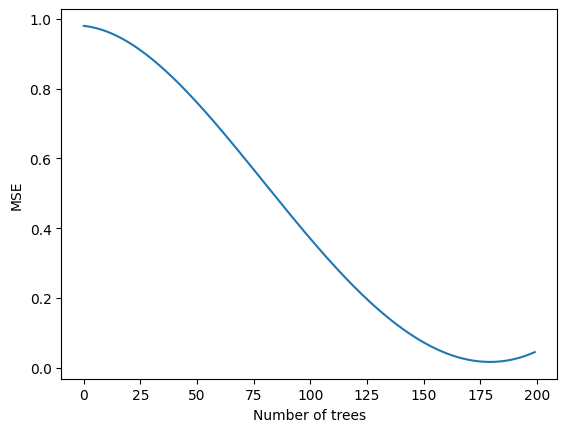

In [44]:
#we do this for 100 trees and plot the mse on the validation set
mses = []
for i in range(200):
    best_split, best_split_dim, min_ssr, best_left_mean, best_right_mean = find_best_split(train, reduced_splits, new_labels)
    models.append((best_split, best_split_dim, best_left_mean, best_right_mean))
    residuals = compute_residuals(train, new_labels, best_split, best_split_dim, best_left_mean, best_right_mean)
    new_labels = update_labels(new_labels, residuals)
    preds = predict_labels_cumulative(models, val)
    preds_arr.append(preds)
    mse = compute_MSE(preds_arr, val_labels)
    mses.append(mse)
    print(i,mse)

    

plt.plot(mses)
plt.xlabel('Number of trees')  
plt.ylabel('MSE')


In [58]:
#find the iteration with the minimum mse
min_mse = min(mses)
min_mse_index = mses.index(min_mse)
print(min_mse, min_mse_index)

0.016581512749156063 179


In [59]:
#use the models upto the iteration with the minimum mse to predict the labels on the test set
testclass0 = x_test[y_test == 0]
testclass1 = x_test[y_test == 1]
print(testclass0.shape, testclass1.shape)   

(980, 784) (1135, 784)


In [60]:
test_labels = [-1]*980 + [1]*1135
test_labels = np.array(test_labels)
test = np.concatenate((testclass0, testclass1), axis=0)

In [61]:
#transform the test data using the PCA transformation matrix
test = test - train_mean_fulldim
test = test @ U
print(test.shape)

(2115, 5)


In [63]:
#predict the labels on the test set
test_preds_arr = []
for i in range(min_mse_index):
    preds = predict_labels_individual(test, models[i][0], models[i][1], models[i][2], models[i][3])
    test_preds_arr.append(preds)
test_preds_arr = np.array(test_preds_arr)
test_mse = compute_MSE_test(test_preds_arr, test_labels)
print(test_mse)


0.00394365125203205
